<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/07-Ensemble_Learning_and_Random_Forests_conGraficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--BOOK_INFORMATION-->
<img align="left" width= 120 style="padding-right:10px;" src="https://covers.oreillystatic.com/images/0636920052289/lrg.jpg">

*Essa aula é inteiramente baseada no **capítulo 7** do livro [Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://shop.oreilly.com/product/0636920052289.do) por Aurélien Geron; os notebooks do livro estão disponíveis [no GitHub](https://github.com/ageron/handson-ml).*

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*Alguns exemplos foram tirados do livro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; disponível [no GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*


# Random Forests


*   Resumo de `Decision Trees`
   * Resolução dos exercícios


1.   Voting Classifiers
2.   Bagging and Pasting
3.   Random Patches and Random Subspaces
4.   Random Forests
5.   Boosting
6.   Stacking
7.   Exercícios

## Resumo de Decision Trees
Na aula passada vimos que as `Decision Trees` são um algoritmo de ML **Supervisionado** e são usadas para **classificar** e **estimar**.

São bastante sensíveis aos hyperparâmetros. Ao usarmos uma `Decision Tree`, devemos escolher com cuidado os parâmetros de input do nosso Estimador/Classificador.


### Exercícios (livro, capítulo 6):

7. Treine e ajuste a `Decision Tree` do conjunto de dados de "luas" (*moon's dataset*).

   1. Gere o conjunto de dados de "luas" usando `make_moons(n_samples=10000, noise=0.4)`;

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

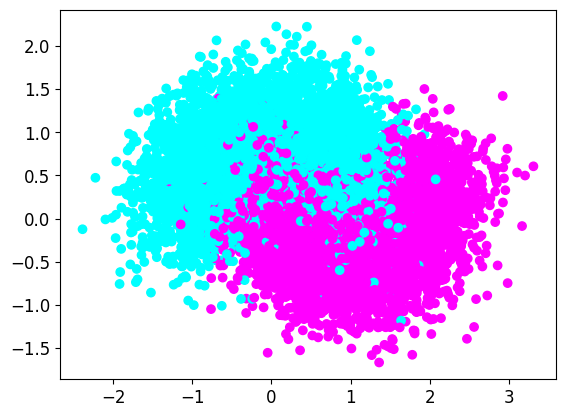

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap="cool")

2. Divida-o em um conjunto de treino e um de teste, usando a função `train_test_split()`;
   
   

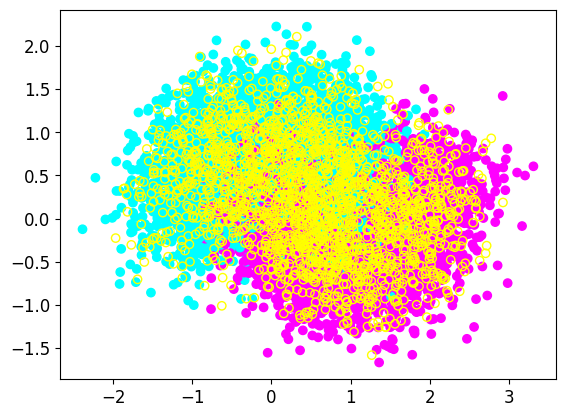

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap="cool")
#em amarelo mostramos os dados de teste, que nosso algoritmo devera classificar
plt.scatter(X_test[:,0],X_test[:,1],color="yellow",facecolor="none")

 3. Use o método de busca com validação cruzada (*grid search with cross-validation*), com a ajuda da classe `GridSearchCV` para encontrar bons valores de hyperparâmetros para um `DecisionTreeClassifier`. Dica: tente diferentes valores para `max_leaf_nodes`;

 **Cross-validation:**


 Quando precisamos testar vários conjuntos de hyperparâmetros para determinar o melhor modelo, se testarmos todos os conjuntos no mesmo conjunto de teste, podemos estar introduzindo um ***bias***. Para evitar isso, podemos sub-dividir nossa amostra de teste em duas amostras:
 * validação (escolha do modelo apropriado)
 * teste (aplicação do melhor modelo)



Para não "gastarmos" dados de treinamento em conjuntos de validação, uma técnica comum é:
* **dividir** a amostra de treinamento em diferentes subconjuntos;
* **treinar** cada modelo (combinações de hyperparâmetros) em uma **combinação** diferente dessas sub-amostras;
* **validar** cada modelo nas sub-amostras restantes;
* Uma vez que o modelo foi determinado, **testar** na amostra de teste.



In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [5]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

1. Treine o estimador no conjunto de dados completo usando esses hyperparâmetros e meça o desempenho do seu modelo no conjunto de dados de teste. Você deve obter uma acurácia de aproximadamente 85% a 87%.

==> **Por default**, o `GridSearchCV` já treina o melhor modelo encontrado no conjunto completo de treinamento (`refit=True`).

Podemos calcular a acurácia diretamente:   
   


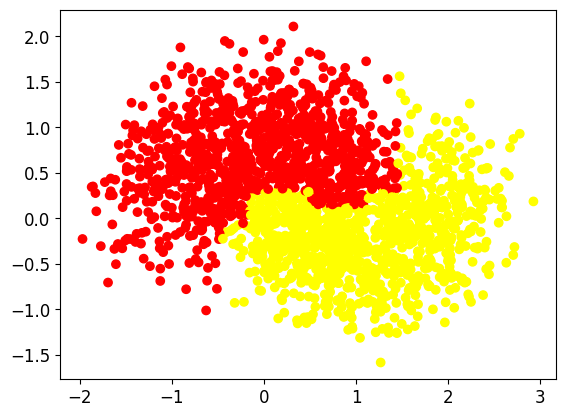

In [6]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

plt.scatter(X_test[:,0],X_test[:,1],c=y_pred,cmap="autumn")

8. **Faça crescer uma floresta.**

   1. Continuando do exercício anterior, gere 1000 sub-conjuntos do conjunto de treinamento, cada sub-conjunto contendo 100 instâncias selecionadas aleatoriamente. Dica: você pode usar a classe do scikit-learn, `ShuffleSplit`;
   
   

In [7]:
print(len(X_train))

8000


In [8]:
from sklearn.model_selection import ShuffleSplit
"""
Geração de n_trees (1000) trees a serem treinadas em conjuntos de
n_instances dados.
Para cada tree, a função rs.split() faz uma rearrumação dos índices de uma sub-amostra de teste
e com isso produz uma mini-amostra de treinamento, com "n_instances" cada.
Nesse exemplo abaixo, geramos "n_trees" amostras com "n_instances" dados cada.

"""
n_trees = 1000
n_instances = 100

mini_sets = []
mini_sets2=[]

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
#USAR O PARAMETRO train_size TAMBEM SERVE E DA O RESULTADO IDENTICO

rs2 = ShuffleSplit(n_splits=n_trees, train_size=n_instances,random_state=42) #tambem serve

for mini_train_index, mini_test_index in rs.split(X_train):
    #print("TRAIN size:", len(mini_train_index), "TEST size:", len(mini_test_index) )
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

for mini_train_index, mini_test_index in rs2.split(X_train):
    #print("TRAIN size:", len(mini_train_index), "TEST size:", len(mini_test_index) )
    X_mini_train2 = X_train[mini_train_index]
    y_mini_train2 = y_train[mini_train_index]
    mini_sets2.append((X_mini_train2, y_mini_train2))
# As "n_trees" amostras de treinamento estão em "mini_sets".
print(len(mini_sets))
print(len(mini_sets2))
print(mini_sets[0][0][0],mini_sets2[0][0][0])
#são identicos

1000
1000
[-0.31532549  0.49432266] [-0.31532549  0.49432266]


1. Treine uma `Decision Tree` em cada sub-conjunto, usando os melhores valores de hyperparâmetro encontrados no exercício anterior. Estime o desempenho desses 1000 conjuntos de treinamento no conjunto de teste (como eles foram treinados em um número menor de amostras, a performance será um pouco pior do que a encontrada no exercício anterior, com uma acurácia em torno de 80%);
   
   

In [9]:
from sklearn.base import clone

# copiando a melhor configuração da tree para todas as "n_trees" trees.
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    # para cada conjunto de treinamento (mini_train), treinamos as nossas trees
    tree.fit(X_mini_train, y_mini_train)
    # fazemos a predição no conjunto de teste
    y_pred = tree.predict(X_test)
    # e calculamos a acurácia de cada predição
    accuracy_scores.append(accuracy_score(y_test, y_pred))
# média das acurácias
np.mean(accuracy_scores)



0.805471

In [10]:
#o máximo e mínimo de acurácia entre os trees
print(np.max(accuracy_scores),np.min(accuracy_scores))

0.8615 0.715


1. Para cada instância do conjunto de teste, gere as predições das 1000 `Decision Trees` e só guarde as predições mais frequentes (você pode usar a função `mode()` do  SciPy). Isso fornece o que é conhecido como *majority vote predictions* do conjunto de teste;
   
   

In [11]:
from scipy.stats import mode

##dou de input a amostra de teste e a "floresta" já treinada

def MyClassifierRandomForest(X_test,forest):
    n_trees = len(forest)
    Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
    for tree_index, tree in enumerate(forest):
        Y_pred[tree_index] = tree.predict(X_test)

    y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
    n_voted = n_votes.reshape([-1])
    y_pred_voted = y_pred_majority_votes.reshape([-1])
    return n_voted,y_pred_voted,Y_pred

1. Estime as predições no conjunto de teste: a acurácia deve ser um pouco maior que a do item anterior (da ordem de 0.5 a 1.5%). **Parabéns!** Você treinou um classificador `Random Forest`! :-)

0.872
256
0.872
Posição do experimento classificado errado: [-0.21010981  0.51683844]


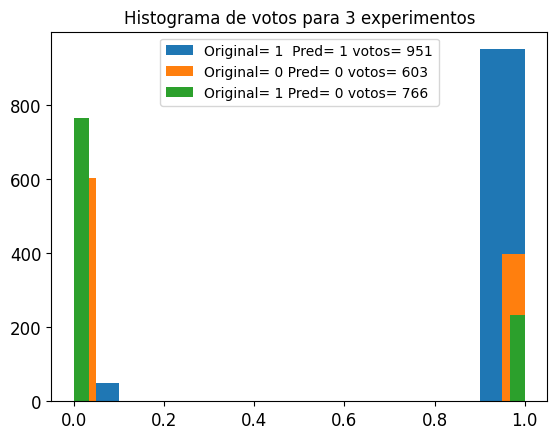

In [12]:
from scipy.stats import mode



n_voted,y_pred_voted,Y_pred = MyClassifierRandomForest(X_test,forest )
print(accuracy_score(y_test, y_pred_voted))



#Os 3 histogramas a continuação mostram a proporção de "votos" para as instancias/experimentos [0], [-1] (o ultimo), o o decimo da lista dos "errados"


plt.hist(Y_pred[:,0],bins=10,label="Original= {:}  Pred= {:} votos= {:d}".format(y_test[0],y_pred_voted[0],int(n_voted[0])))

plt.hist(Y_pred[:,-1],bins=20,label="Original= {:} Pred= {:} votos= {:d}".format(y_test[-1],y_pred_voted[-1],int(n_voted[-1])))

w=np.where(y_test!=y_pred_voted) #selecionar as instancias onde o random forest escolheu errado
print(len(w[0]))
print(1-len(w[0])/len(y_test)) # checar que é o mesmo valor que o accuracy_score
ind10 = w[0][10]
plt.hist(Y_pred[:,ind10],bins=30,label="Original= {:} Pred= {:} votos= {:d}".format(y_test[ind10],y_pred_voted[w[0][10]],int(n_voted[ind10])))
plt.title("Histograma de votos para 3 experimentos")
plt.legend(loc="upper center")

print("Posição do experimento classificado errado:",X_test[ind10])



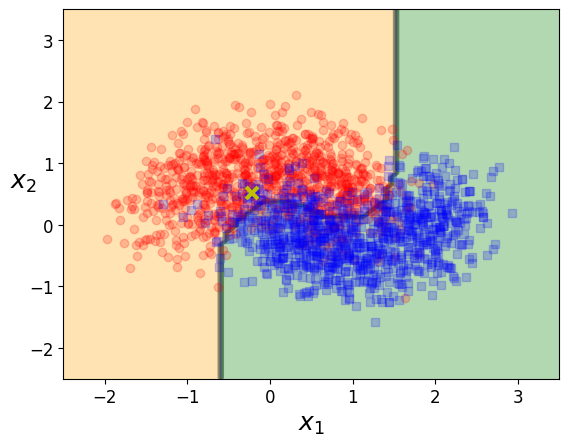

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_RandomForest(clf, X, y, axes=[-2.5, 3.5, -2.5, 3.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred =  clf(X_new,forest)[1].reshape(x1.shape)
    custom_cmap = ListedColormap(['orange','black','green'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.7)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", alpha=0.2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=0.2)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    return plt

plot_decision_RandomForest(MyClassifierRandomForest,X_test,y_test)

##o X amarelo mostra o ponto que foi classificado como "0"  mas na verdade era "1"
plt.plot(X_test[ind10,0],X_test[ind10,1],"yx",markersize=8,mew=3)

## Ensemble Learning e Random Forests

**Ensemble learning**: método onde se usa a informação **agregada** de um conjunto (*ensemble*) de estimadores (classificadores ou métodos de regressão) para se obter uma estimativa.


\\
**Random Forests**:
* treinar um grupo de `Decision Trees` em subconjuntos (aleatórios distintos) do conjunto de treinamento;
* para fazer predições, obtém-se a predição de cada `Decision Tree` individualmente;
* a predição final é o valor que ocorre com mais frequência.

### Voting Classifiers
(Clasificadores de votação)

![hard voting](https://i.stack.imgur.com/W7UmY.png)


Criação e treinamento de um 'voting classifier' usando 'scikit-learn':

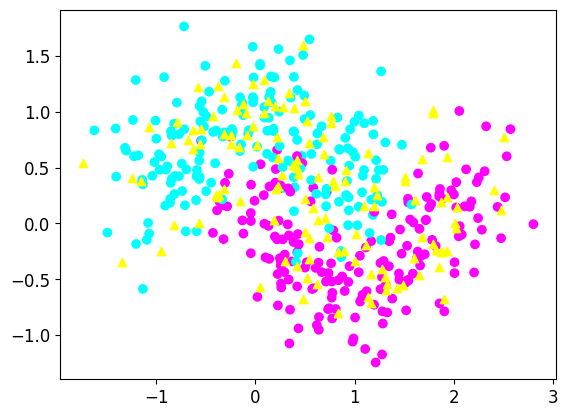

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap="cool")
plt.scatter(X_test[:,0],X_test[:,1],color="yellow", marker="^")

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') # estimators : list of (string, estimator) tuples

In [16]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [17]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 200)
    x2s = np.linspace(axes[2], axes[3], 200)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)




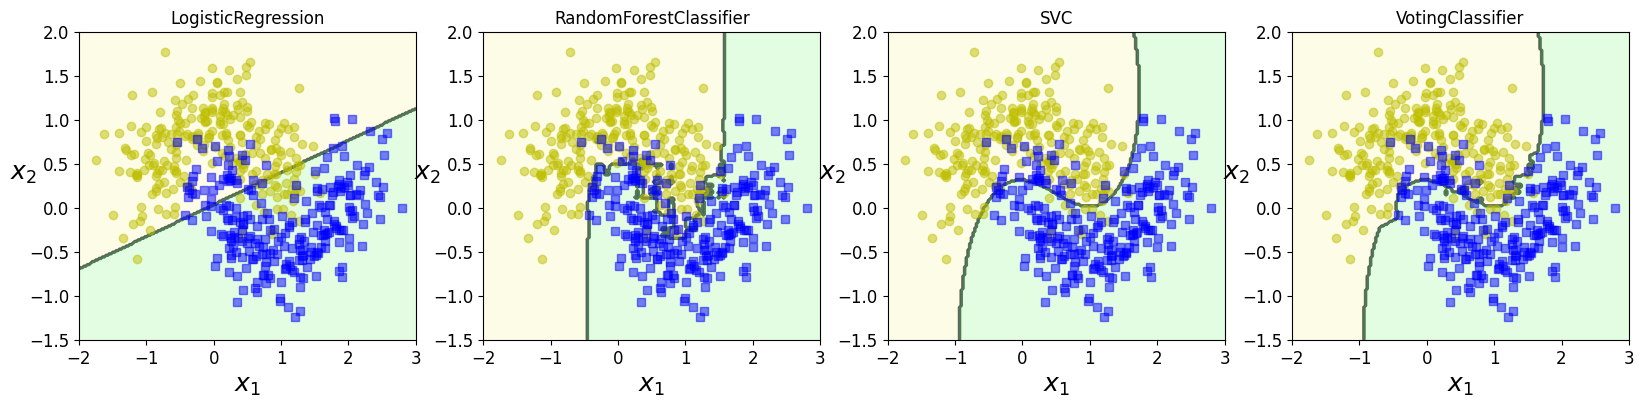

In [19]:
plt.figure(figsize=(20,4))

for i,clf in enumerate((log_clf, rnd_clf, svm_clf, voting_clf)):
    plt.subplot(int(141+i))
    plot_decision_boundary(clf,X,y,axes=[-2,3,-1.5,2])
    plt.title(str(clf.__class__.__name__))


No exemplo acima, o 'Voting Classifier' obteve uma acurácia maior que as dos outros classificadores considerados individualmente.

obs.:  Quanto mais independentes os classificadores usados no 'Ensemble Learning', melhor a performance.

Podemos também considerar as probabilidades de classificação, considerando que os classificadores têm o método 'predict_proba()' e decidir pelo classificador com a maior média das probabilidades.

In [20]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42) # temos que forçar o SVC a calcular a probabilidade

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [21]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


Text(0.5, 1.0, 'VotingClassifier Hard')

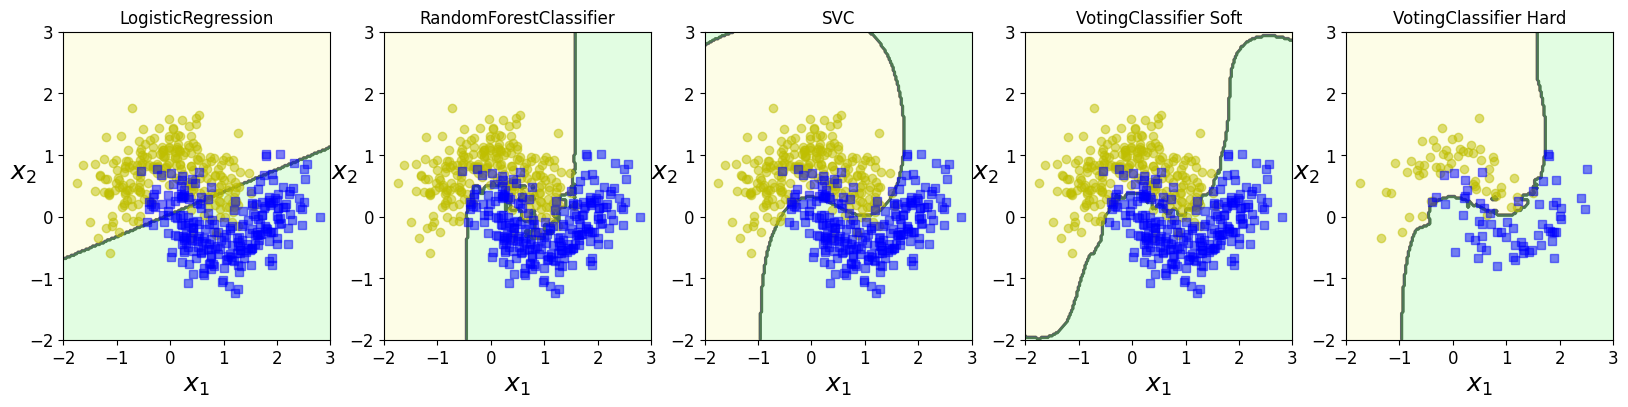

In [22]:
plt.figure(figsize=(20,4))


for i,clf in enumerate([log_clf, rnd_clf, svm_clf]):
    plt.subplot(int(151+i))
    plot_decision_boundary(clf,X,y,axes=[-2,3,-2,3])
    plt.title(str(clf.__class__.__name__))
plt.subplot(154)
plot_decision_boundary(voting_clf_soft,X,y,axes=[-2,3,-2,3])
plt.title(str(voting_clf_soft.__class__.__name__)+" Soft")
plt.subplot(155)
plot_decision_boundary(voting_clf,X_test,y_test,axes=[-2,3,-2,3])
plt.title(str(voting_clf_soft.__class__.__name__)+" Hard")

### Bagging and Pasting

**Bagging**: **B**ootstrap **aggr**egat**ing** ==> amostragem com substituição (*sampling with replacement*): seleção de uma sub-amostra escolhida aleatoriamente de uma amostra, podendo haver **reutilização de valores**. Quer dizer que em uma sub-amostra para treinamento pode se repetir o mesmo ponto dos dados 0, 1 ou mais vezes.

**Pasting**: amostragem **sem reutilização de valores**. Ou seja cada ponto dos dados pode aparecer numa sub-amostra no máximo 1 vez, mas pode aparecer em mais de uma sub-amostra.

![bagging](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*iskng0M2Qv9GF0CADcl0Ww.png)

A função de agregação é em geral o `hard voting` para classificadores e a média das probabilidades para a regressão.

#### Bagging ensembles

Um classificador `bagging` com o `scikit-learn`:

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)



BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=42)

In [24]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


Um classificador de `Decision Tree`

In [25]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))



0.856


Abaixo comparamos os limites de decisão da `Decision Tree` com o `Bagging` usando o conjunto de dados `moon's dataset`.

O método de ensemble generaliza melhor os dados do que uma única `Decision Tree`.

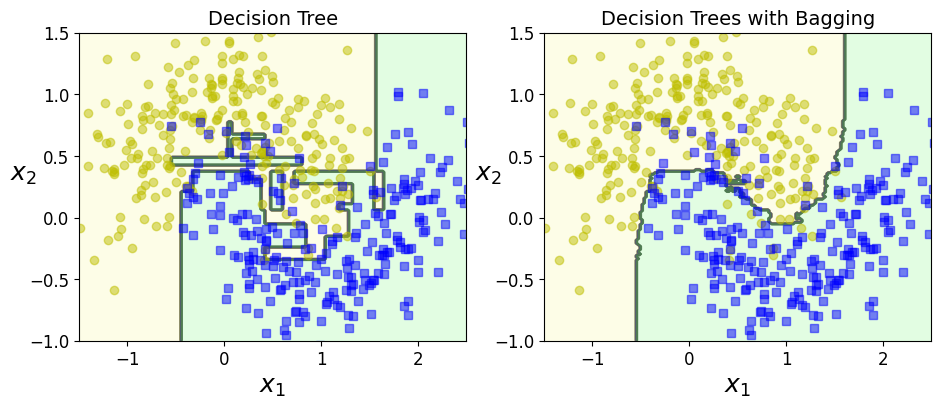

In [26]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

**Exercício**: Faça a representação gráfica dos limites de decisão de uma `Decision Tree`, do método de `Bagging` e do método de **`Pasting`** com 500 `Decision Trees` treinadas em amostras aleatórias de 100 instâncias cada, usando a mesma amostra do `moon's dataset`.

### Random Patches e Random Subspaces

O Classificador `Bagging` também permite que se faça a amostragem nas `features` também (além das instâncias).

> **Método `Random Patch`**: amostragem das instâncias e `features`;

> **Método de `Random Subspaces`**: amostragem somente nas `features`.


## Random Forests

Podemos usar o método `RandomForestClassifier` do `scikit-learn` para uso das Random Forests.

O algoritmo `RandomForestClassifier` introduz uma aleatoriedade ainda maior ao ***crescer árvores***: ao invés de escolher a melhor `feature` para o limite de decisão das `Decision Trees` da "floresta", ele escolhe a melhor `feature` de um subconjunto de `features`, escolhido aleatoriamente.

In [27]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))

0.912


Podemos escrever um método de `Bagging` para produzir um `RandomForestCalssifier`:

In [28]:
bag_clf_boots = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf_boots.fit(X_train, y_train)

y_pred_bc = bag_clf_boots.predict(X_test)

print(accuracy_score(y_test, y_pred_bc))

0.92


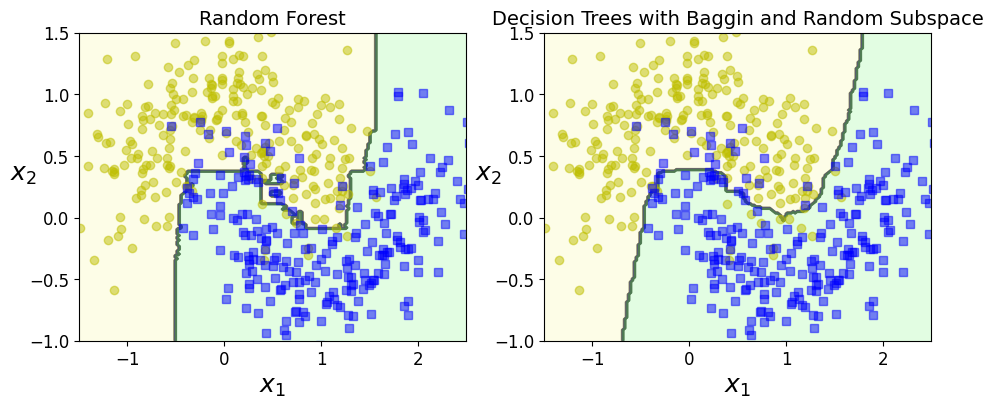

In [29]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf_boots, X, y)
plt.title("Decision Trees with Baggin and Random Subspace" , fontsize=14)


plt.show()

### Extra Trees

É possível introduzir ainda mais aleatoriedade ao método de `Random Forests`, estabelecendo os limiares (`thresholds`) dos atributos (`features`) de forma aleatória (ao invés de procurar pelo melhor `threshold`) ==> **Extremely Randomized Trees ensemble**

`ExtraTreesClassifier` e `ExtraTreesRegressor` estão disponíveis no `scikit-learn`.

$\boxed{\text{Em geral é difícil dizer a priori qual o melhor método a se usar. O ideal é testar ambos e e comparar suas performances.} }$

## Boosting

Boosting é uma técnica geral que se refere a qualquer método de ensemble em que a ***combinação de estimadores/classificadores fracos individualmente, resulta em um método forte***.

Boosting: treinar estimadores **sequencialmente**, cada um tentando corrigir o seu antecessor.

Dica: Assista a
[aula de Boosting do MIT Open Courseware](https://youtu.be/UHBmv7qCey4?si=x_UwxDcb9pG1s9Nj). Boosting funciona com qualquer classificador, não só árvores ou _stumps_ de árvores.

### AdaBoosting

("Ada" de adaptar)

Um forma do novo estimador corrigir o antecessor é olhando para os casos de "underfitting". O resultado são novos estimadores que focam mais e mais nos casos difíceis.

Por exemplo:

1. Temos uma `Decision Tree` que classificou erroneamente algumas instâncias de treinamento;
2. O peso relativo das instâncias mal classificadas é aumentado e passado para o estimador sucessor;
3. O segundo classificador é treinado com esses pesos, faz predições e atualiza os pesos, que são passados para o quarto classificador e assim por diante.

![adaboosting](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*dhrecywXzYS5QvuRq79xYw.png)

A seguir, treinamos um classificador `AdaBoost` baseado em 200 `Decision Stumps` (que é uma `Decision Tree` com `max_depth=1`).

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [31]:
y_pred_ada = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ada))

0.896


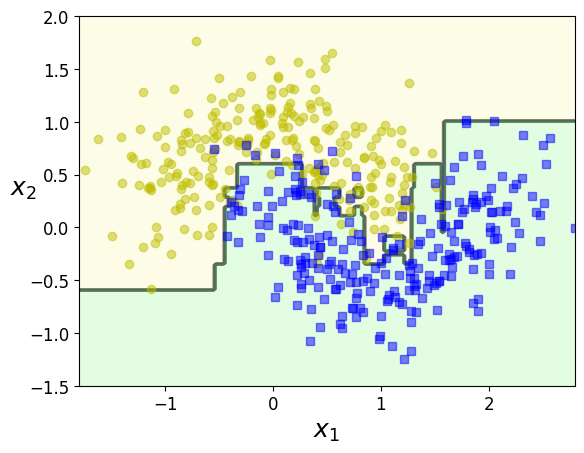

In [32]:
plot_decision_boundary(ada_clf, X, y,axes=[-1.8,2.8,-1.5,2.0])

Se o `AdaBoosting` estiver fazendo overfitting e "decorando" a amostra de treinamento, pode-se ajustar os hyperparâmetros `n_estimators`, `learning_rate`, ou tentar ***regularizar*** os estimadores base.






### Gradient Boosting

Assim como o `AdaBoosting`, o `Gradient Boosting` trabalha com estimadores sequenciais, cada um corrigindo o seu antecessor.

Mas ao invés de aplicar pesos para corrigir o estimador antecessor, o `Gradient Boosting` tenta ajustar o novo estimador aos **erros residuais** do antecessor e assim corrigir a estimativa anterior.

Vamos ver um exemplo de um estimador para uma função quadrática com ruído.

In [33]:
def quadratic_plus_noise(m = 100):
  """Quadratic training set + noise
    m: number of samples
  """
  np.random.seed(42)
  X = np.random.rand(m, 1) - 0.5
  y = 3*X[:, 0]**2 + 0.05 * np.random.randn(m)
  return X, y

X, y = quadratic_plus_noise()

O primeiro estimador é uma `Decision Tree`. Vamos fazer a predição e olhar para os resíduos:

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)



DecisionTreeRegressor(max_depth=2, random_state=42)

In [35]:
#resíduos:
y2 = y - tree_reg1.predict(X)
# tree sucessora:
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)


DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Treinamos nosso método de ensemble com 3 `Decision Trees`, ajustando as duas últimas aos erros residuais.

Vamos ver como nosso `Gradient Descent` prediz o valor de y para x=0.8

In [37]:
X_new = np.array([[0.8]])
# o gradient descent é a soma dos resultados das 3 Decision Trees
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

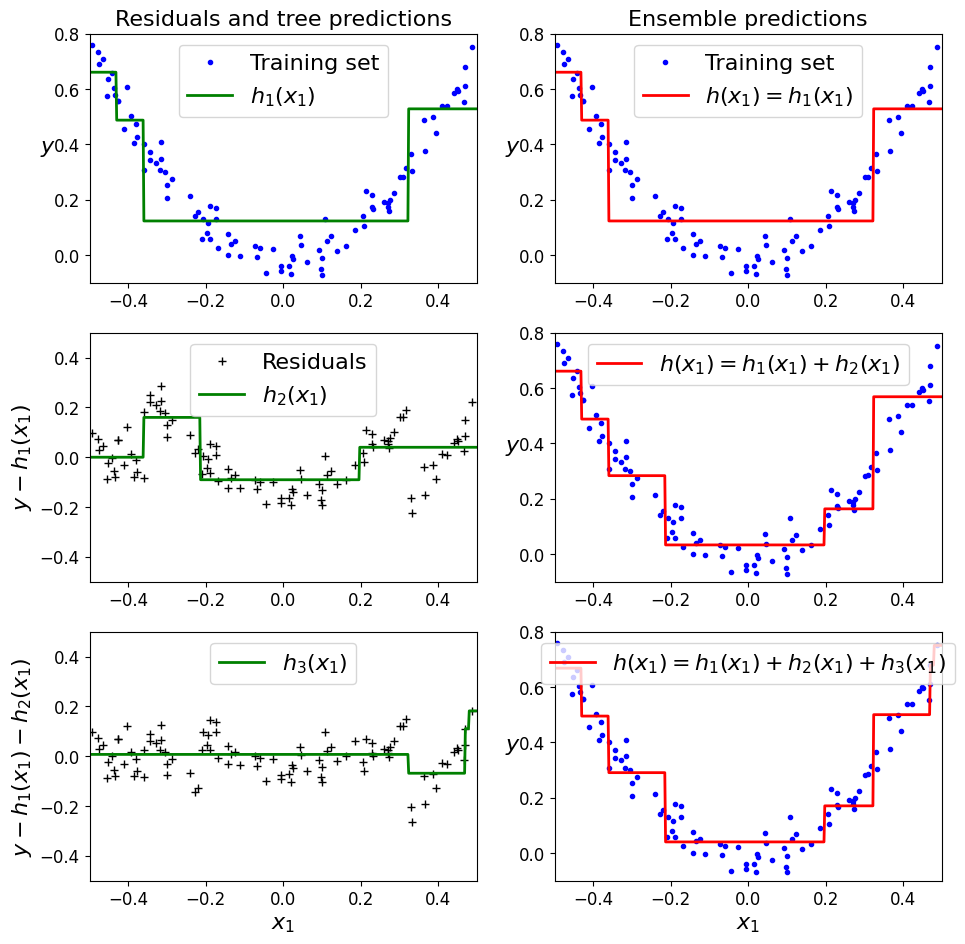

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

O `scikit-learn` tem uma classe que implementa o `GradientBoostingRegressor Tree` (GBRT).

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

O hyperparâmetro `learning_rate`, controla a contribuição de cada `Tree` do GBRT.

Quanto menor a `learning_rate`, maior o número de `Trees` (`n_estimators`) necessários. Mas em geral, as predições são melhores ==> técnica de ***shrinkage*** (encolhimento).

Vejamos dois exemplos de shrinkage, um com **underfitting** e outro com **overfitting**:

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)



GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [41]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

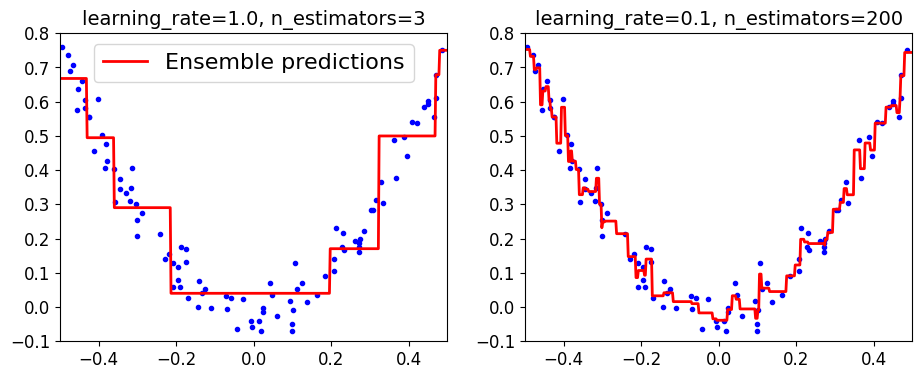

In [42]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

### Gradient Boosting com `early stopping` (parada precoce)
Para encontrar o número ideal de `Trees` podemos usar a técnica de *early stopping*:
1. calcular o erro de validação a cada estágio do treinamento (com uma, duas, três, ... `Trees`)
2. encontrar o número ideal de `Trees`;
3. Treinar outro ensemble GBRT usando o número ideal de `Trees`.

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

#calculo do erro para cada estágio da validação
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# o número de Trees será igual ao estágio em que o erro é o menor
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [44]:
min_error = np.min(errors)
print(min_error)

0.002712853325235463


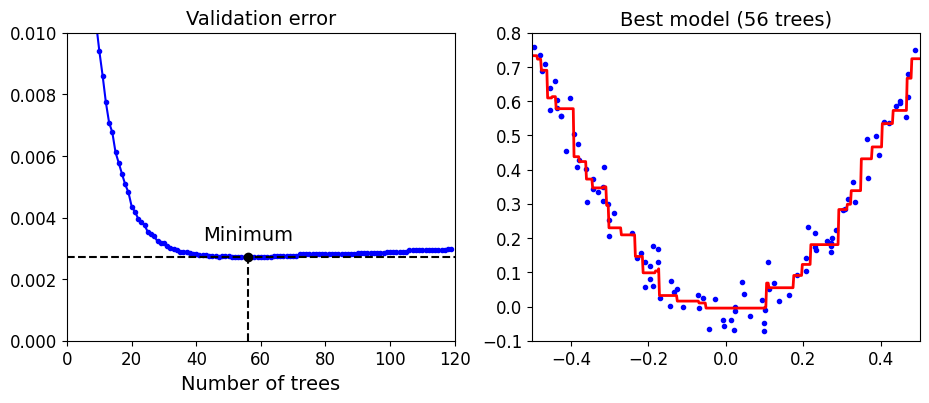

In [45]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()


“Também é possível implementar a parada precoce, interrompendo o treinamento mais cedo.

Você pode fazer isso configurando `warm_start = True`, o que faz o Scikit-Learn manter as árvores existentes quando o método fit () é chamado, permitindo treinamento incremental. O código a seguir interrompe o treinamento quando o erro de validação não melhora por cinco iterações seguidas. ”

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [47]:
print(gbrt.n_estimators)


61


In [48]:
print("Minimum validation MSE:", min_val_error)


Minimum validation MSE: 0.002712853325235463


## Ensemble Stacking

Uma outra forma de combinar diferentes classificadores é o stacking ou *stacked generalization* é usar um modelo para aprender como combiná-los da melhor maneira possível. Os classificadores individuais dão uma predição que um algoritmo que podemos chamar de _blender_ vai combinar para dar a predição final.

![stacking](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kn495g6dkXUmwi0yth1FUQ.png)

Vamos ver um exemplo com a classificação de números

In [54]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [55]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [56]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

Vamos combinar 4 classificadores : Random forest, extra trees, support vector machine e um multilevel perceptron

In [57]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [58]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)


Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [59]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9614]

In [60]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [61]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

Agora chamamos um classificador de random forest para combinar.

In [62]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [63]:
rnd_forest_blender.oob_score_

0.97

In [67]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

y_pred = rnd_forest_blender.predict(X_test_predictions)

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9691

Neste caso, não melhora muito em comparação com os melhores dos nossos classificadores individuais.

Mas pode-se tentar "sintonizar" alguns hiperparametros deste _blender_ (liquidificador 😅) ou testar outros algoritmos = (e.g., an MLPClassifier) para combinar e escolher o melhor usando _cross-validation_.



In [97]:
params = {'hidden_layer_sizes': [20, 50,100], 'learning_rate_init': [0.001, 0.01, 0.1], 'learning_rate':['constant','adaptive']}
gsearch_mlp_blender = GridSearchCV(MLPClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

In [98]:
gsearch_mlp_blender.fit(X_val_predictions,y_val)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [20, 50, 100],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.001, 0.01, 0.1]},
             verbose=1)

In [99]:
gsearch_mlp_blender.best_estimator_

MLPClassifier(hidden_layer_sizes=100, learning_rate_init=0.01, random_state=42)

In [100]:
y_pred_mlpblend = gsearch_mlp_blender.predict(X_test_predictions)

In [101]:
accuracy_score(y_test,y_pred_mlpblend)

0.9631